In [ ]:
#upload dataset zip file
from google.colab import files
uploaded = files.upload()

Saving trash sorting.v2i.tensorflow.zip to trash sorting.v2i.tensorflow.zip


In [ ]:
#extract data
import zipfile
import os

zip_path = "trash sorting.v2i.tensorflow.zip"
extract_path = "/content/trash_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted to:", extract_path)

Extracted to: /content/trash_data


First few rows:
                                            filename  width  height    class  \
0  63175eb17be1e63175eb17be24_frame57_jpg.rf.be5b...    640     640  Plastic   
1  63971668873496397166887351_frame1_jpg.rf.bfc3e...    640     640    Metal   
2  63971668873496397166887351_frame1_jpg.rf.bfc3e...    640     640      Bin   
3  62c692e42087e62c692e420884_frame45_jpg.rf.bf6c...    640     640      Bin   
4  62c692e42087e62c692e420884_frame45_jpg.rf.bf6c...    640     640    Metal   

   xmin  ymin  xmax  ymax  
0   347   341   541   492  
1     1   245   331   550  
2     4    12   639   466  
3     1     0   571   441  
4   141   245   279   306  

Class distribution:
class
Glass      779
Metal      645
Bin        636
Plastic    362
Other       24
Name: count, dtype: int64


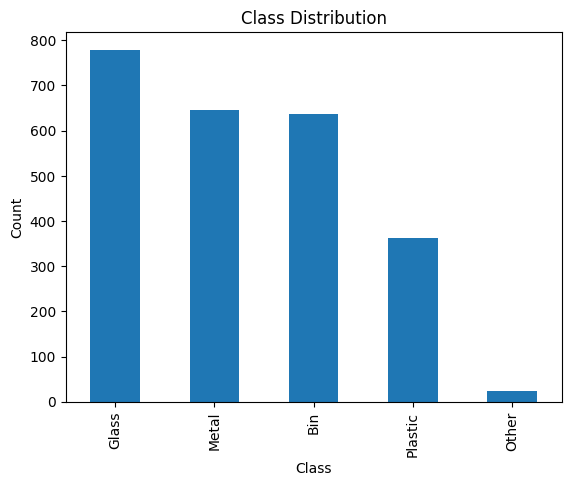

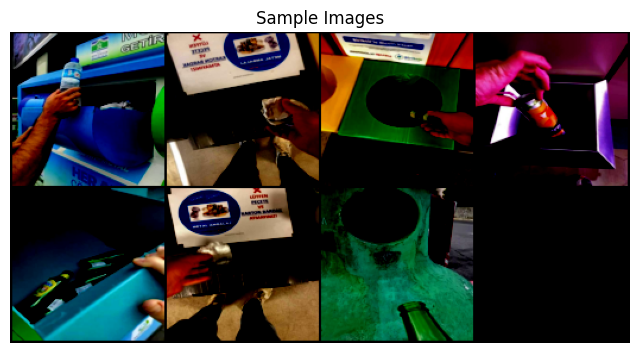

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from collections import Counter

#set data path
data_dir = "/content/trash_data/train"
annotations_file = os.path.join(data_dir, '_annotations.csv')

#load annotations
df = pd.read_csv(annotations_file)

#EDA

print("First few rows:")
print(df.head())
print("\nClass distribution:")
print(df['class'].value_counts())

#class distribution
df['class'].value_counts().plot(kind='bar', title='Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

#custom Dataset
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = self.img_labels.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
        return image, label

#image transformation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

#dataset and dataloader
dataset = CustomImageDataset(annotations_file=annotations_file, img_dir=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

#display simple images
import torchvision
images, labels = next(iter(dataloader))
img_grid = torchvision.utils.make_grid(images[:8], nrow=4)
plt.figure(figsize=(8, 8))
plt.imshow(img_grid.permute(1, 2, 0))  #CHW to HWC because matplotlib only understands HWC (but pyTorch uses CHW)
plt.title("Sample Images")
plt.axis('off')
plt.show()

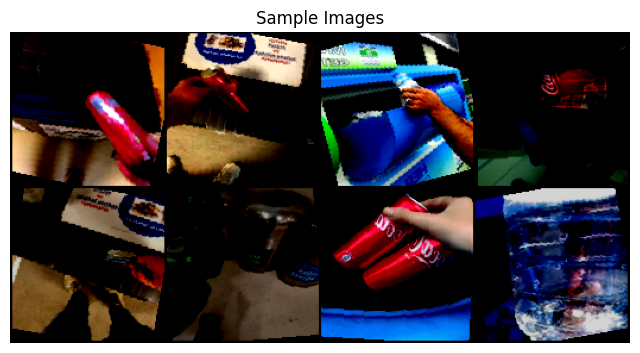

In [ ]:
#visualize advanced transformations

augmented_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

dataset = CustomImageDataset(annotations_file=annotations_file, img_dir=data_dir, transform=augmented_transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

images, labels = next(iter(dataloader))
img_grid = torchvision.utils.make_grid(images[:8], nrow=4)
plt.figure(figsize=(8, 8))
plt.imshow(img_grid.permute(1, 2, 0))
plt.title("Sample Images")
plt.axis('off')
plt.show()

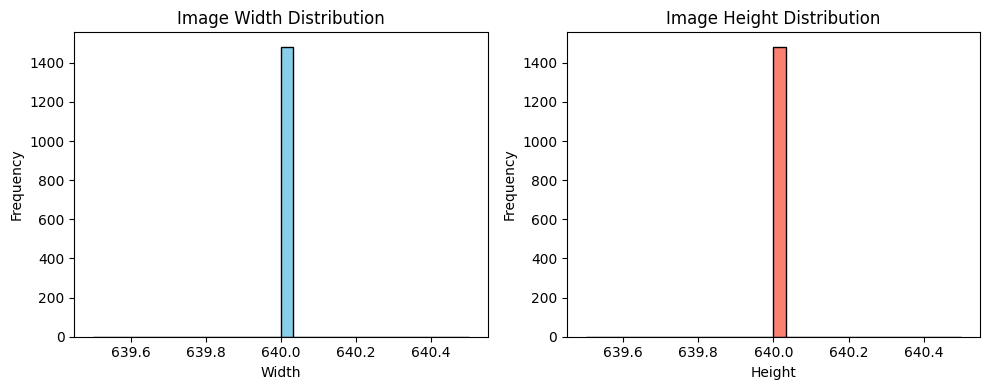

In [ ]:
#check original images size distribution in train/test/val sets

def get_image_sizes(image_folder):
    widths, heights = [], []
    for filename in os.listdir(image_folder):
        if filename.lower().endswith(('jpg', 'jpeg', 'png')):
            try:
                with Image.open(os.path.join(image_folder, filename)) as img:
                    width, height = img.size
                    widths.append(width)
                    heights.append(height)
            except:
                continue
    return widths, heights

image_folder = "/content/trash_data/train"  #for training set
widths, heights = get_image_sizes(image_folder)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=30, color='skyblue', edgecolor='black')
plt.title('Image Width Distribution')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(heights, bins=30, color='salmon', edgecolor='black')
plt.title('Image Height Distribution')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

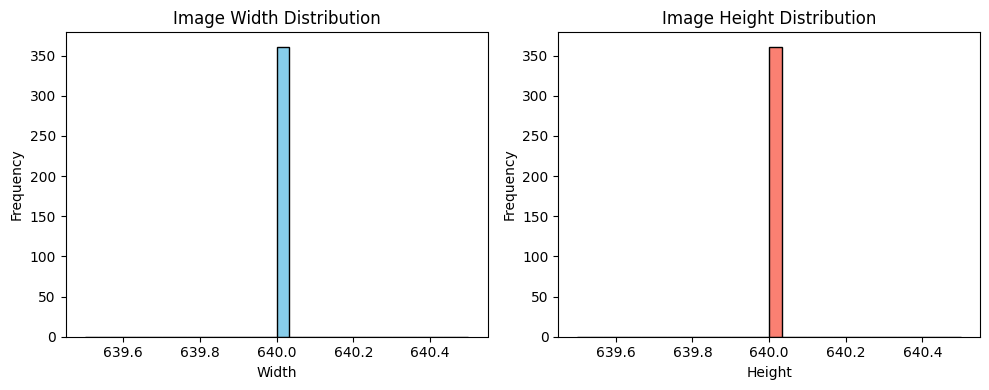

In [ ]:
image_folder = "/content/trash_data/test"  #for test set
widths, heights = get_image_sizes(image_folder)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=30, color='skyblue', edgecolor='black')
plt.title('Image Width Distribution')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(heights, bins=30, color='salmon', edgecolor='black')
plt.title('Image Height Distribution')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

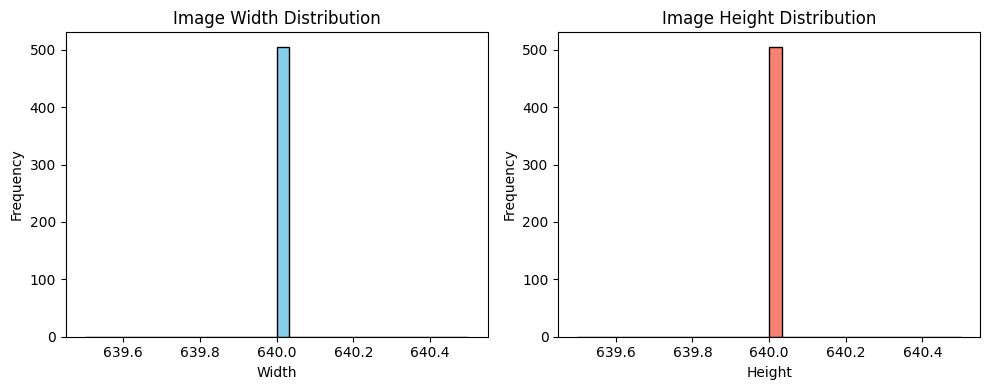

In [ ]:
image_folder = "/content/trash_data/valid"  #for validation set
widths, heights = get_image_sizes(image_folder)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=30, color='skyblue', edgecolor='black')
plt.title('Image Width Distribution')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(heights, bins=30, color='salmon', edgecolor='black')
plt.title('Image Height Distribution')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import os
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt
import time

base_dir = "/content/trash_data"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "valid")
test_dir = os.path.join(base_dir, "test")

IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

#loading annotation CSVs
train_df = pd.read_csv(os.path.join(train_dir, '_annotations.csv'))
val_df = pd.read_csv(os.path.join(val_dir, '_annotations.csv'))
test_df = pd.read_csv(os.path.join(test_dir, '_annotations.csv'))

#path to images
train_df['filename'] = train_df['filename'].apply(lambda x: os.path.join(train_dir, x))
val_df['filename'] = val_df['filename'].apply(lambda x: os.path.join(val_dir, x))
test_df['filename'] = test_df['filename'].apply(lambda x: os.path.join(test_dir, x))

#convert class column to string
train_df['class'] = train_df['class'].astype(str)
val_df['class'] = val_df['class'].astype(str)
test_df['class'] = test_df['class'].astype(str)

#image brightness and contrast enhancement before training
def enhance_image(path):
    try:
        img = Image.open(path).convert("RGB")
        img = ImageEnhance.Brightness(img).enhance(1.2)
        img = ImageEnhance.Contrast(img).enhance(1.3)
        img.save(path)
    except Exception as e:
        print(f"Failed to enhance {path}: {e}")

print("Enhancing brightness/contrast of training images...")
for path in train_df['filename']:
    enhance_image(path)

#data generators
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=15)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_gen.class_indices)
print("Number of classes:", num_classes)

#calculating class weights for imbalance handling
y_train = train_df['class'].astype('category').cat.codes.to_numpy()
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weight_dict)

Enhancing brightness/contrast of training images...
Found 2446 validated image filenames belonging to 5 classes.
Found 814 validated image filenames belonging to 5 classes.
Found 603 validated image filenames belonging to 5 classes.
Number of classes: 5
Class Weights: {0: np.float64(0.769182389937107), 1: np.float64(0.6279845956354301), 2: np.float64(0.7584496124031008), 3: np.float64(20.383333333333333), 4: np.float64(1.3513812154696132)}


In [ ]:
#build the basic model
model = Sequential([
    InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])

#compile model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,036,229 (72.62 MB)

 Trainable params: 19,036,229 (72.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#train the model
epochs = 10
start_time = time.time()
history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen
)
print("Training time:", int(time.time() - start_time), "seconds")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.3587 - loss: 1.8496 - val_accuracy: 0.6081 - val_loss: 0.8480
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.7036 - loss: 0.6465 - val_accuracy: 0.7236 - val_loss: 0.6667
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.7287 - loss: 0.4993 - val_accuracy: 0.7174 - val_loss: 0.5852
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.7321 - loss: 0.4881 - val_accuracy: 0.7248 - val_loss: 0.5597
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.7397 - loss: 0.4622 - val_accuracy: 0.7359 - val_loss: 0.5202
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.7522 - loss: 0.4660 - val_accuracy: 0.7310 - val_loss: 0.5278
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.7395 - loss: 0.4293 - val_accuracy: 0.7211 - val_loss: 0.5415
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.7530 - loss: 0.4420 - val_accuracy: 0.6990 - v

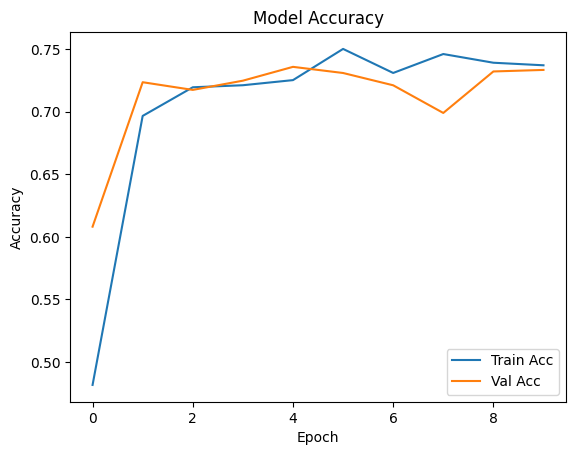

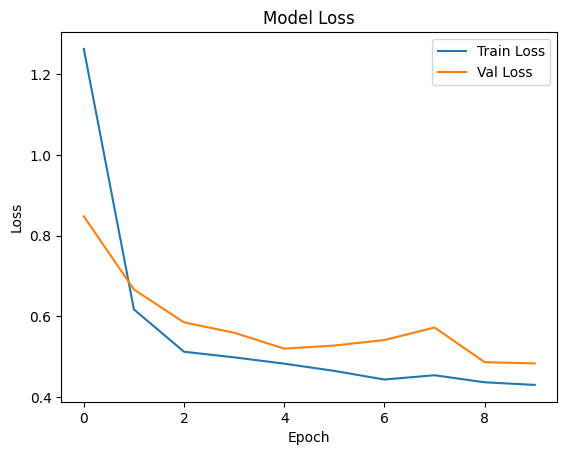

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 447ms/step - accuracy: 0.7323 - loss: 0.4543
Test Accuracy: 0.7230514287948608


In [ ]:
#plot accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#save model
model.save('trash_classifier_model.h5')

#evaluate on test data
test_loss, test_acc = model.evaluate(test_gen)
print("Test Accuracy:", test_acc)

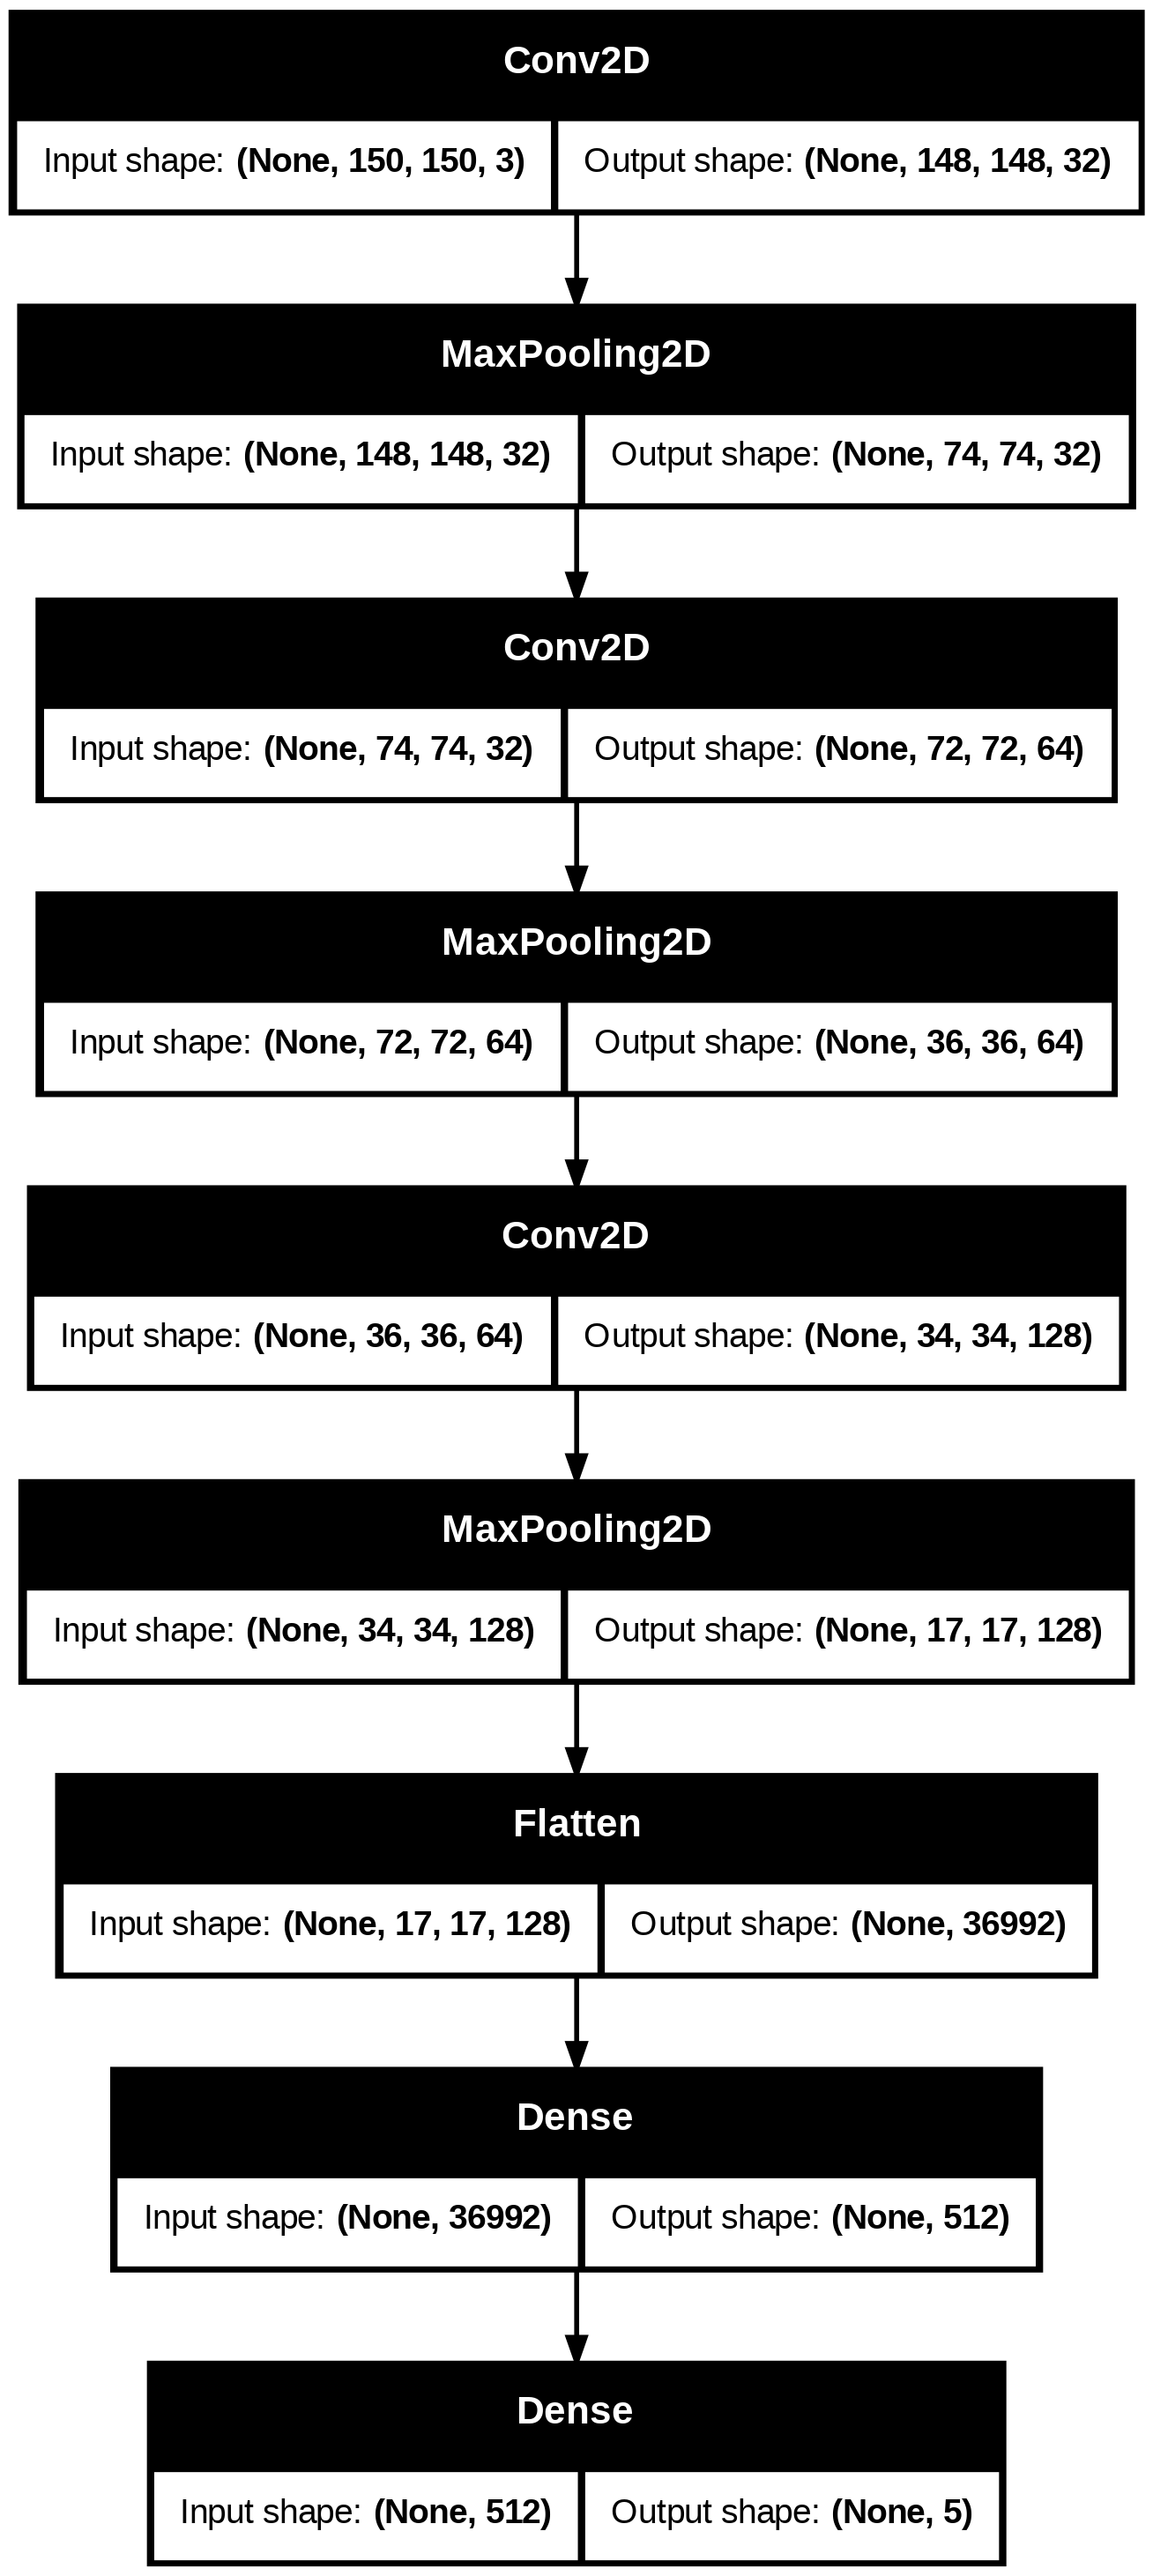

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='basic_model.png', show_shapes=True)

In [ ]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 36.6 MB/s eta 0:00:00


In [ ]:
import visualkeras

visualkeras.layered_view(model, legend=True, draw_volume=True, to_file="basic_model_visual.png").show()

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


In [ ]:
#advanced model
from tensorflow.keras import regularizers

model_improved = Sequential([
    InputLayer(input_shape=(150, 150, 3)),

    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001),
           kernel_initializer='glorot_uniform', padding='valid'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Dropout(0.5),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001),
           kernel_initializer='glorot_uniform', padding='valid'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Dropout(0.5),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001),
           kernel_initializer='glorot_uniform', padding='valid'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Dropout(0.5),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001),
           kernel_initializer='glorot_uniform', padding='valid'),
    MaxPooling2D(pool_size=(2, 2), padding='valid'),
    Dropout(0.5),

    #dense block
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Multi-class classification
])

#compile model
model_improved.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

model_improved.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,455,173 (13.18 MB)

 Trainable params: 3,455,173 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
]

#train model
history = model_improved.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=callbacks
)

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2434 - loss: 1.9121

77/77 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.2438 - loss: 1.9103 - val_accuracy: 0.4337 - val_loss: 1.8368
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3265 - loss: 1.6682

77/77 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.3263 - loss: 1.6681 - val_accuracy: 0.4189 - val_loss: 1.8358
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3630 - loss: 1.6158

77/77 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.3629 - loss: 1.6158 - val_accuracy: 0.4558 - val_loss: 1.8250
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3602 - loss: 1.6028

77/77 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.3604 - loss: 1.6026 - val_accuracy: 0.5098 - val_loss: 1.8114
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4150 - loss: 1.5488

77/77 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.4151 - loss: 1.5483 - val_accuracy: 0.4361 - val_loss: 1.7652
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4402 - loss: 1.4804

77/77 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.4403 - loss: 1.4799 - val_accuracy: 0.4619 - val_loss: 1.7249
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4788 - loss: 1.4015

77/77 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.4789 - loss: 1.4011 - val_accuracy: 0.5012 - val_loss: 1.6855
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5657 - loss: 1.2663

77/77 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.5657 - loss: 1.2661 - val_accuracy: 0.4644 - val_loss: 1.6375
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6020 - loss: 1.1101

77/77 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.6019 - loss: 1.1103 - val_accuracy: 0.4717 - val_loss: 1.5860
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6261 - loss: 1.0704

77/77 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.6260 - loss: 1.0704 - val_accuracy: 0.4312 - val_loss: 1.5634


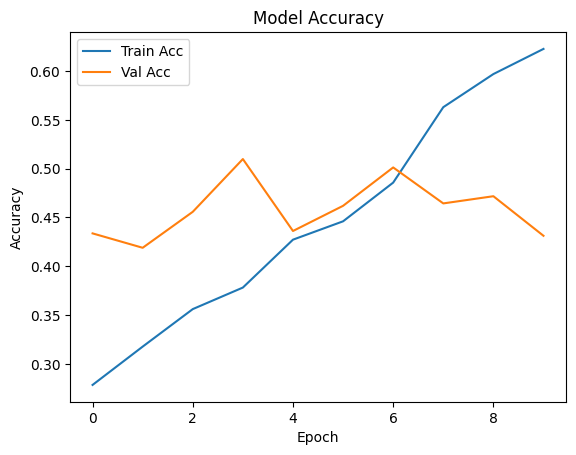

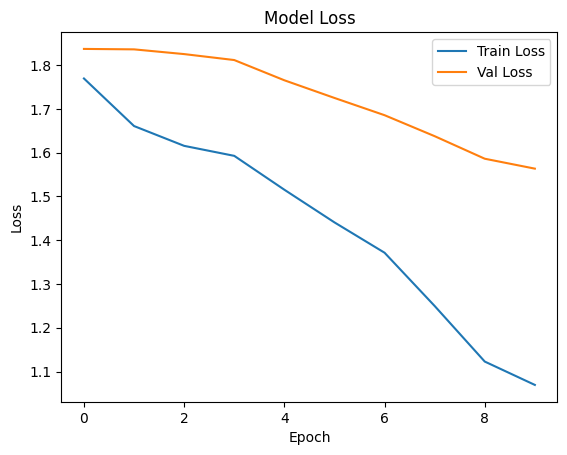

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 477ms/step - accuracy: 0.4194 - loss: 1.6071
Test Accuracy: 0.41791045665740967


In [ ]:
#plot accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#save model
model_improved.save('trash_classifier_model.h5')

#evaluate on test data
test_loss, test_acc = model_improved.evaluate(test_gen)
print("Test Accuracy:", test_acc)

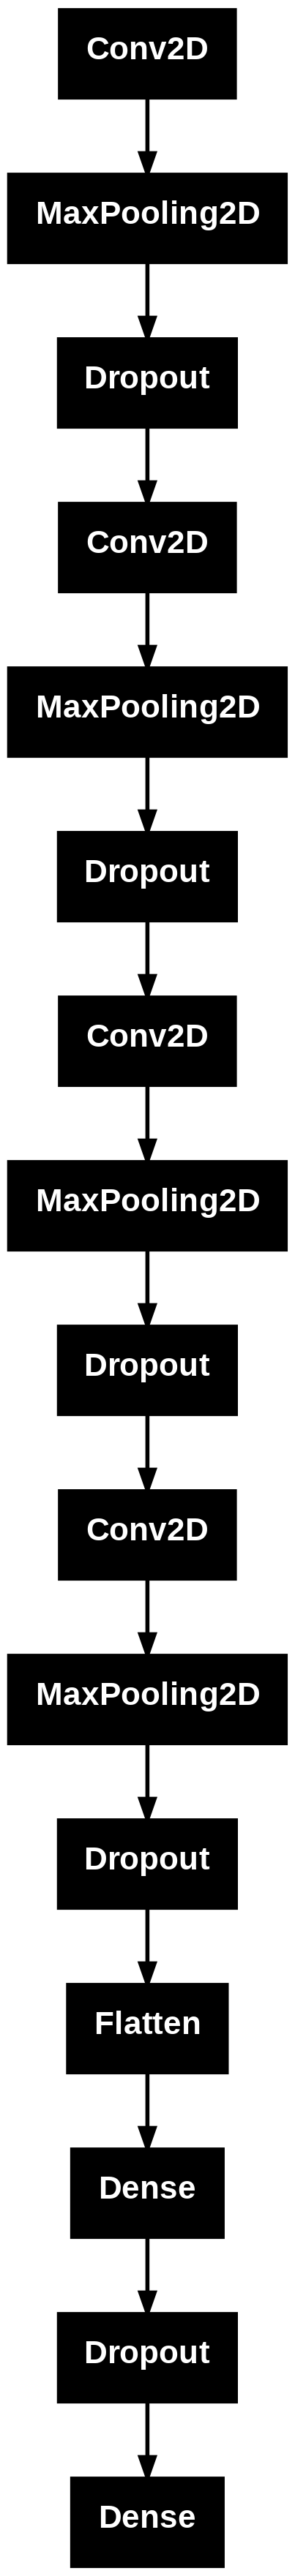

In [ ]:
plot_model(model_improved, to_file='improved_model.png', show_shapes=False)

In [ ]:
visualkeras.layered_view(model_improved, legend=True, draw_volume=True, to_file="improved_model_visual.png").show()

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


In [ ]:
# Hyperparameters to tune
batch_sizes = [32, 64]
dropout_rates = [0.3, 0.5]
epochs_list = [20, 30]

IMG_HEIGHT = 150
IMG_WIDTH = 150

# Read annotation CSV
train_dir = "/content/trash_data/train"
train_df = pd.read_csv(os.path.join(train_dir, '_annotations.csv'))
train_df['filename'] = train_df['filename'].apply(lambda x: os.path.join(train_dir, x))
train_df['class'] = train_df['class'].astype(str)

# Encode labels for StratifiedKFold
y = train_df['class'].astype('category').cat.codes.to_numpy()

# K-Fold Cross-validation setup
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
best_val_acc = 0
best_model_path = "best_model_tuned.h5"

# Loop through all hyperparameter combinations
for batch_size in batch_sizes:
    for dropout_rate in dropout_rates:
        for num_epochs in epochs_list:
            fold = 1
            print(f"\n=== Trying batch_size={batch_size}, dropout_rate={dropout_rate}, epochs={num_epochs} ===")
            val_scores = []

            for train_idx, val_idx in kf.split(train_df, y):
                train_data = train_df.iloc[train_idx].copy()
                val_data = train_df.iloc[val_idx].copy()

                # Data Generators
                train_gen = ImageDataGenerator(rescale=1./255, rotation_range=15, horizontal_flip=True)
                val_gen = ImageDataGenerator(rescale=1./255)


                train_flow = train_gen.flow_from_dataframe(
                    dataframe=train_data,
                    x_col='filename',
                    y_col='class',
                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                    batch_size=batch_size,
                    class_mode='categorical'
                )
                val_flow = val_gen.flow_from_dataframe(
                    dataframe=val_data,
                    x_col='filename',
                    y_col='class',
                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                    batch_size=batch_size,
                    class_mode='categorical'
                )

                num_classes = len(train_flow.class_indices)

                # Build model
                def build_model():
                    model = Sequential([
                        InputLayer(input_shape=(150, 150, 3)),

                        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
                        MaxPooling2D((2, 2)),
                        Dropout(dropout_rate),

                        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
                        MaxPooling2D((2, 2)),
                        Dropout(dropout_rate),

                        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
                        MaxPooling2D((2, 2)),
                        Dropout(dropout_rate),

                        Flatten(),
                        Dense(512, activation='relu'),
                        Dropout(dropout_rate),
                        Dense(num_classes, activation='softmax')
                    ])
                    model.compile(
                        optimizer=Adam(learning_rate=0.0001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy']
                    )
                    return model

                model = build_model()

                # Class weights
                y_train_codes = train_data['class'].astype('category').cat.codes.to_numpy()
                weights = class_weight.compute_class_weight(
                    class_weight='balanced',
                    classes=np.unique(y_train_codes),
                    y=y_train_codes
                )
                weight_dict = dict(enumerate(weights))

                # Callbacks
                def lr_schedule(epoch):
                    return 0.001 * (0.1 ** int(epoch / 10))

                callbacks = [
                    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss'),
                    LearningRateScheduler(lr_schedule)
                ]

                # Train model
                history = model.fit(
                    train_flow,
                    validation_data=val_flow,
                    epochs=num_epochs,
                    class_weight=weight_dict,
                    callbacks=callbacks,
                    verbose=0
                )

                val_acc = max(history.history['val_accuracy'])
                print(f"Fold {fold} - Val Accuracy: {val_acc:.4f}")
                val_scores.append(val_acc)
                fold += 1

            avg_val_acc = np.mean(val_scores)
            print(f"Average Val Accuracy: {avg_val_acc:.4f}")

            # Save best model
            if avg_val_acc > best_val_acc:
                best_val_acc = avg_val_acc
                model.save(best_model_path)
                best_params = (batch_size, dropout_rate, num_epochs)

print(f"\n Best Model Saved: {best_model_path}")
print(f"Best Params -> Batch Size: {best_params[0]}, Dropout: {best_params[1]}, Epochs: {best_params[2]}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")